<a href="https://colab.research.google.com/github/RiseAboveAll/RSNA_Pneumonia/blob/master/Akash_Interim_RSNA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 106kB/s 


In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import pydicom

import csv
import random

from glob import glob #The glob module finds all the pathnames matching a specified pattern according to the rules
import os

import tensorflow as tf
from tensorflow import keras

from skimage import measure
from skimage.transform import resize
from PIL import Image
from sklearn.model_selection import train_test_split as tts

import math
import cv2

from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
Path='/content/drive/My Drive/Capstone/'

In [ ]:
Image_Path='/content/drive/My Drive/Capstone/train_images/'

In [ ]:
os.chdir(Path)

# Data Loading

In [ ]:
detailed_class_df=pd.read_csv('stage_2_detailed_class_info.csv')
train_label_df=pd.read_csv('stage_2_train_labels.csv')

In [ ]:
detailed_class_df.describe()

,patientId,class
count,30227,30227
unique,26684,3
top,1bf08f3b-a273-4f51-bafa-b55ada2c23b5,No Lung Opacity / Not Normal
freq,4,11821


There are potentially 3543 repetetive X-Rays of one patient , because the patients must have been asked to get his or her x-ray after some interval to see the progress or how worse the situation is 

In [ ]:
train_label_df.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


- It seems most of the bounding boxes for the X-Rays are not square, probably because of high lung opacity  

- This tells us that there are NaN present in the bounding box features, total missing values are 20672

- Let us indentify the reason behind the missing values 


In [ ]:
train_label_df.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

- This shows that out of 30227 , 20672 do not have pneumonia , hence this is the reason behind missing values in bounding box features 


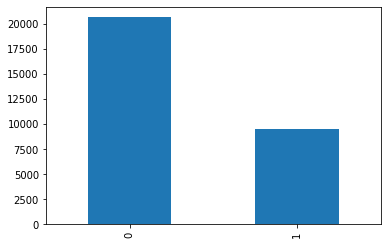

In [ ]:
train_label_df.Target.value_counts().plot(kind='bar')

- This shows that there is the imbalance in the classes, **we need to treat these imbalances** 

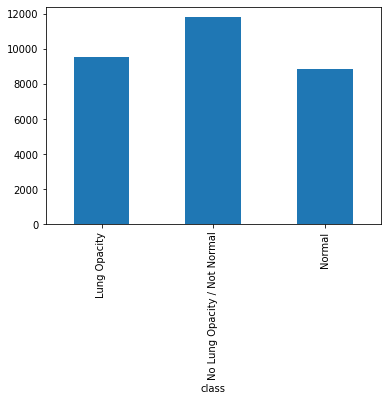

In [ ]:
detailed_class_df.groupby('class').size().plot(kind='bar')

This shows in majority X-Rays there are no lung opacity though but still the XRay is not normal , the patient is suffering from the health issue

Hence for patients whose XRAY does not show opacity but still are not normal, our target label has marked them as 0 because the algorithm can not detect the opacity and show it using the bounding box  

## Combining both Data Frame - Inner Join

In [ ]:
Final_Data = pd.concat([train_label_df, 
                        detailed_class_df.drop('patientId',1)], 1)
print(Final_Data.shape[0], 'combined cases')
Final_Data.sample(3)

30227 combined cases


,patientId,x,y,width,height,Target,class
20041,b8a18a7b-502a-487a-98aa-0edd1c1126cb,724.0,660.0,195.0,163.0,1,Lung Opacity
28040,f8a11cd6-e541-4765-a41b-3d70b6f3481e,NaN,NaN,NaN,NaN,0,Normal
25991,e833c9ab-b130-4cda-a56d-a526a7615536,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [ ]:
Final_Data.isna().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64

In [ ]:
for i in ['x','y','width','height']:
    Final_Data[i].replace(np.NAN,0,inplace=True)

In [ ]:
Final_Data.head(3)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal


In [ ]:
box_df = Final_Data.groupby('patientId').size().reset_index(name='boxes')
box_df

,patientId,boxes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,1
1,000924cf-0f8d-42bd-9158-1af53881a557,1
2,000db696-cf54-4385-b10b-6b16fbb3f985,2
3,000fe35a-2649-43d4-b027-e67796d412e0,2
4,001031d9-f904-4a23-b3e5-2c088acd19c6,2
...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,2
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,1
26681,fffc95b5-605b-4226-80ab-62caec682b22,1
26682,fffcff11-d018-4414-971a-a7cefa327795,1


In [ ]:
Final_Data = pd.merge(Final_Data, box_df, on='patientId')

In [ ]:
Final_Data.shape

(30227, 8)

In [ ]:
Final_Data.head()

,patientId,x,y,width,height,Target,class,boxes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal,1
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,2


In [ ]:
box_df.groupby('boxes').size().reset_index(name='patients')

,boxes,patients
0,1,23286
1,2,3266
2,3,119
3,4,13


- There are 23286 patients with 1 bounding box , i.e majority of patients have 1 bounding box . But we want to know that patients having boxes are they having the underlying problem or not ? This 23286 number number does not match to number of patients having pneumonia , Hence we need to go in depth and identify the actual scenario

In [ ]:
Tbox_df = Final_Data.groupby(['patientId','Target']).size().reset_index(name='boxes')
Tbox_df

,patientId,Target,boxes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,1
1,000924cf-0f8d-42bd-9158-1af53881a557,0,1
2,000db696-cf54-4385-b10b-6b16fbb3f985,1,2
3,000fe35a-2649-43d4-b027-e67796d412e0,1,2
4,001031d9-f904-4a23-b3e5-2c088acd19c6,1,2
...,...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,1,2
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,0,1
26681,fffc95b5-605b-4226-80ab-62caec682b22,0,1
26682,fffcff11-d018-4414-971a-a7cefa327795,0,1


In [ ]:
Tbox_df.groupby(['boxes','Target']).size().reset_index(name='patients')

,boxes,Target,patients
0,1,0,20672
1,1,1,2614
2,2,1,3266
3,3,1,119
4,4,1,13


- Now here you see out of 23286 patients there are 2614 patients only who have the underlying problem, 20672 patients do not have and they do not also have bounding box , there coordinates are just marked 0 , i.e why it is being shown as 1 bounding box 

In [ ]:
Final_Data.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


In [ ]:
path=os.getcwd()+'/'+'train_images/'

In [ ]:
path

'/content/drive/My Drive/Capstone/train_images/'

In [ ]:
patientID=set(Final_Data.patientId)

In [ ]:
pid=list(patientID)

In [ ]:
id=[]
for i in range(len(patientID)):
    id.append(path+pid[i]+'.dcm')

In [ ]:
id[1]

'/content/drive/My Drive/Capstone/train_images/3f79f27a-6d84-4ff1-88a2-eb05ff9a5f57.dcm'

In [ ]:
image_df=pd.DataFrame([patientID,id])
image_df=image_df.T
image_df.columns=['patientId','Path']
box_pat_ids = set(Final_Data['patientId'].values.tolist())
assert patientID.union(box_pat_ids)==patientID

In [ ]:
Final_Data_df= pd.merge(Final_Data, 
                         image_df, 
                         on='patientId',
                        how='left').sort_values('patientId')
print(Final_Data_df.shape[0], 'image bounding boxes')
Final_Data_df.head(5)

30227 image bounding boxes


,patientId,x,y,width,height,Target,class,boxes,Path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,1,/content/drive/My Drive/Capstone/train_images/...
28989,000924cf-0f8d-42bd-9158-1af53881a557,0.0,0.0,0.0,0.0,0,Normal,1,/content/drive/My Drive/Capstone/train_images/...
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,/content/drive/My Drive/Capstone/train_images/...
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,/content/drive/My Drive/Capstone/train_images/...
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,/content/drive/My Drive/Capstone/train_images/...


In [ ]:
image_meta_df=pd.read_csv('Image_Data.csv')

In [ ]:
image_meta_df.head()

,patientId,x,y,width,height,Target,class,Path,xmin,xmax,ymin,ymax,boxes,PatientAge,BodyPartExamined,ViewPosition,PatientSex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,0,0,0,0,No Lung Opacity / Not Normal,/content/drive/My Drive/Capstone/train_images/...,0,0,0,0,1,51.0,CHEST,PA,F
1,000924cf-0f8d-42bd-9158-1af53881a557,0,0,0,0,0,Normal,/content/drive/My Drive/Capstone/train_images/...,0,0,0,0,1,19.0,CHEST,AP,F
2,000db696-cf54-4385-b10b-6b16fbb3f985,316,318,170,478,1,Lung Opacity,/content/drive/My Drive/Capstone/train_images/...,316,486,318,796,2,25.0,CHEST,AP,F
3,000db696-cf54-4385-b10b-6b16fbb3f985,660,375,146,402,1,Lung Opacity,/content/drive/My Drive/Capstone/train_images/...,660,806,375,777,2,25.0,CHEST,AP,F
4,000fe35a-2649-43d4-b027-e67796d412e0,570,282,269,409,1,Lung Opacity,/content/drive/My Drive/Capstone/train_images/...,570,839,282,691,2,40.0,CHEST,AP,M


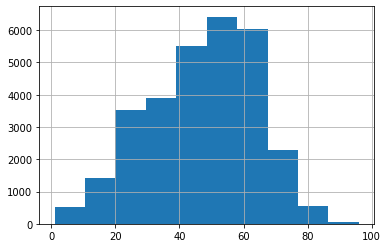

In [ ]:
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)
image_meta_df['PatientAge'].hist()

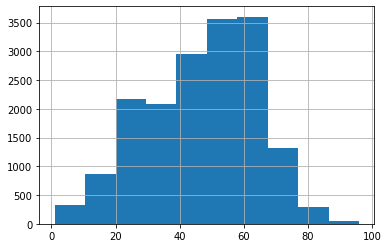

In [ ]:
image_meta_df['PatientAge'][image_meta_df.PatientSex=='M'].hist()

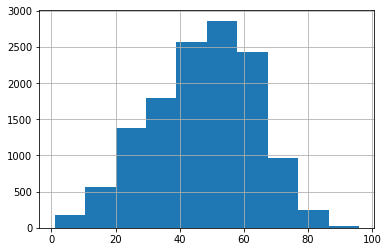

In [ ]:
image_meta_df['PatientAge'][image_meta_df.PatientSex=='F'].hist()

- We can see that patients in majority we of age between 35-65

- When we split it on basis of Gender we found out that for females majority lies between 35 - 65, whereas for males its between 45-65

- We can also see that there is an empty gap after age of 99, there seems to be potential outliers, hence we need to address them 

In [ ]:
def outlier(col):
    IQR=image_meta_df[col].quantile(.75)-image_meta_df[col].quantile(.25)
    upper_bound=image_meta_df[col].quantile(.75) + ( 1.5 * IQR)
    lower_bound=image_meta_df[col].quantile(.25) - ( 1.5 * IQR)
    image_meta_df[col].clip(lower=lower_bound,upper=upper_bound,inplace=True)

{'boxes': [<matplotlib.lines.Line2D at 0x7f6a3592e470>],
 'caps': [<matplotlib.lines.Line2D at 0x7f6a3592ee80>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6a3593d940>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f6a3593d5c0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f6a3592e780>,
  <matplotlib.lines.Line2D at 0x7f6a3592eb00>]}

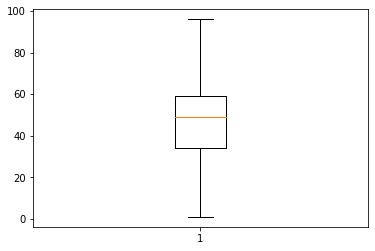

In [ ]:
plt.boxplot(image_meta_df.PatientAge)

In [ ]:
outlier('PatientAge')

{'boxes': [<matplotlib.lines.Line2D at 0x7f6a358e4a58>],
 'caps': [<matplotlib.lines.Line2D at 0x7f6a358d3518>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6a358d3f98>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f6a358d3c18>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f6a358c5dd8>,
  <matplotlib.lines.Line2D at 0x7f6a358d3198>]}

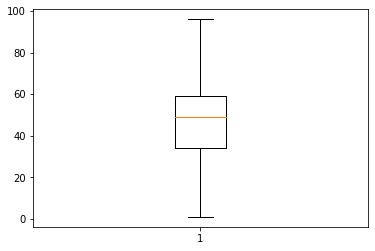

In [ ]:
plt.boxplot(image_meta_df.PatientAge)

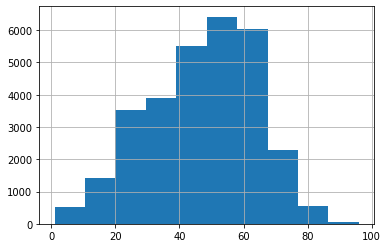

In [ ]:
image_meta_df['PatientAge'].hist()

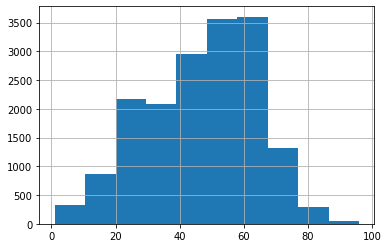

In [ ]:
image_meta_df['PatientAge'][image_meta_df.PatientSex=='M'].hist()

In [ ]:
print('Mean Age of Male',image_meta_df['PatientAge'][image_meta_df.PatientSex=='M'].mean())
print('Mean Age of Female',image_meta_df['PatientAge'][image_meta_df.PatientSex=='F'].mean())

Mean Age of Male 46.643761617100374
Mean Age of Female 46.98024748289909


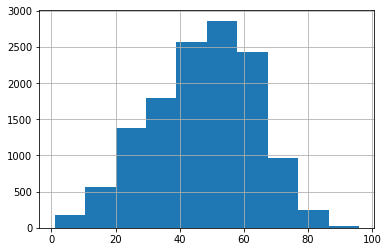

In [ ]:
image_meta_df['PatientAge'][image_meta_df.PatientSex=='F'].hist()

Now you can see that we have removed the outliers 

We can see that patients in majority we of age between 38-75

Post removing outlier, we see the change that  When we split it on basis of Gender, for females majority lies between 38 - 58, whereas for males its between 50-75

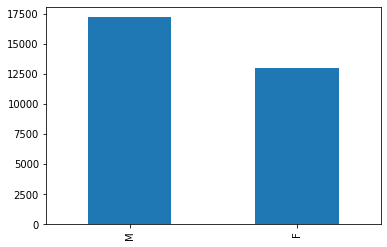

In [ ]:
image_meta_df.PatientSex.value_counts().plot(kind='bar')

In [ ]:
image_meta_df.PatientSex.value_counts()

M    17216
F    13011
Name: PatientSex, dtype: int64

We can see that Males are in majority whose XRays are being conducted , we can say that approximately every 3rd person going for XRAY is Female 

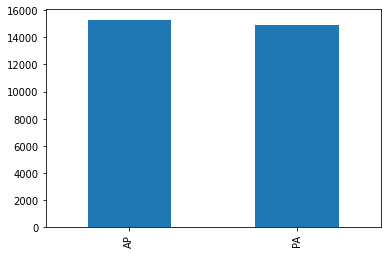

In [ ]:
image_meta_df.ViewPosition.value_counts().plot(kind='bar')

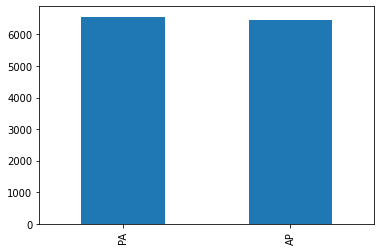

In [ ]:
image_meta_df.ViewPosition[image_meta_df.PatientSex=='F'].value_counts().plot(kind='bar')

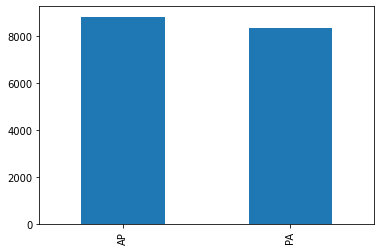

In [ ]:
image_meta_df.ViewPosition[image_meta_df.PatientSex=='M'].value_counts().plot(kind='bar')

- We can see that there is not much difference between **posteroanterior** & **anteroposterior** View Position of X-Rays 

- There is no difference in distribution as such on based on Gender 

In [ ]:
image_meta_df.drop(['Path','patientId'],1).describe(exclude=np.number)

,class,BodyPartExamined,ViewPosition,PatientSex
count,30227,30227,30227,30227
unique,3,1,2,2
top,No Lung Opacity / Not Normal,CHEST,AP,M
freq,11821,30227,15297,17216


In [ ]:
image_meta_df.head(3)

,patientId,x,y,width,height,Target,class,Path,xmin,xmax,ymin,ymax,boxes,PatientAge,BodyPartExamined,ViewPosition,PatientSex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,0,0,0,0,No Lung Opacity / Not Normal,/content/drive/My Drive/Capstone/train_images/...,0,0,0,0,1,51,CHEST,PA,F
1,000924cf-0f8d-42bd-9158-1af53881a557,0,0,0,0,0,Normal,/content/drive/My Drive/Capstone/train_images/...,0,0,0,0,1,19,CHEST,AP,F
2,000db696-cf54-4385-b10b-6b16fbb3f985,316,318,170,478,1,Lung Opacity,/content/drive/My Drive/Capstone/train_images/...,316,486,318,796,2,25,CHEST,AP,F


In [ ]:
sample_df = Final_Data_df.groupby(['Target','class', 'boxes']).apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).reset_index(drop=True)
sample_df

,patientId,x,y,width,height,Target,class,boxes,Path
0,b4587e51-7fa7-4264-84a0-2c000f98c0a3,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,1,/content/drive/My Drive/Capstone/train_images/...
1,d5231546-354e-4071-9af1-6644beabfd86,0.0,0.0,0.0,0.0,0,Normal,1,/content/drive/My Drive/Capstone/train_images/...
2,6dc49720-b500-4b82-8909-08bc243ea4df,186.0,421.0,143.0,143.0,1,Lung Opacity,1,/content/drive/My Drive/Capstone/train_images/...
3,c38ac8c2-2de1-4e9c-8c38-1b09d89dec5e,541.0,303.0,206.0,462.0,1,Lung Opacity,2,/content/drive/My Drive/Capstone/train_images/...
4,c38ac8c2-2de1-4e9c-8c38-1b09d89dec5e,125.0,274.0,246.0,502.0,1,Lung Opacity,2,/content/drive/My Drive/Capstone/train_images/...
5,308eab64-517b-46f1-8865-d9566b087bff,354.0,501.0,111.0,90.0,1,Lung Opacity,3,/content/drive/My Drive/Capstone/train_images/...
6,308eab64-517b-46f1-8865-d9566b087bff,695.0,558.0,172.0,105.0,1,Lung Opacity,3,/content/drive/My Drive/Capstone/train_images/...
7,308eab64-517b-46f1-8865-d9566b087bff,366.0,639.0,172.0,68.0,1,Lung Opacity,3,/content/drive/My Drive/Capstone/train_images/...
8,3239951b-6211-4290-b237-3d9ad17176db,198.0,370.0,204.0,205.0,1,Lung Opacity,4,/content/drive/My Drive/Capstone/train_images/...
9,3239951b-6211-4290-b237-3d9ad17176db,558.0,649.0,174.0,186.0,1,Lung Opacity,4,/content/drive/My Drive/Capstone/train_images/...


In [ ]:
sample_df.shape

(12, 9)

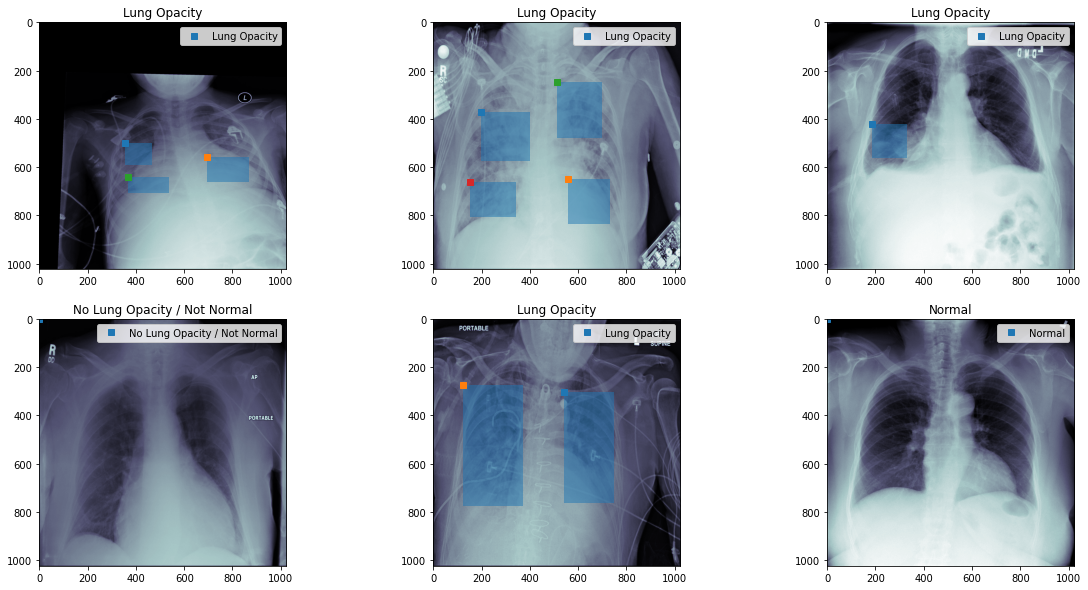

In [ ]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),sample_df.groupby(['Path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

## Bounding Box Distribution

In [ ]:
image_full_df=pd.read_csv('Image_Data.csv')

### Understanding the x & y coordinates 

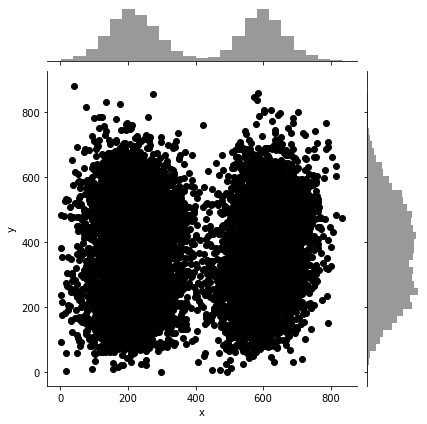

In [ ]:
sns.jointplot(x="x", y="y", data=image_full_df[image_full_df.x >0],color='k')

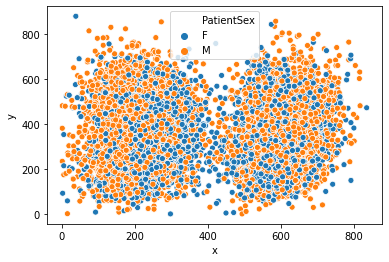

In [ ]:
sns.scatterplot(image_full_df.x[image_full_df.x >0],image_full_df.y[image_full_df.x >0],hue=image_full_df.PatientSex[image_full_df.x >0])

On the basis of gender :

- For Females , in their left lung, opacity is being found in mostly right portion , as you can see the high concentration 

- For Females , in their right lung, opacity is being found in mostly left portion , as you can see the high concentration 

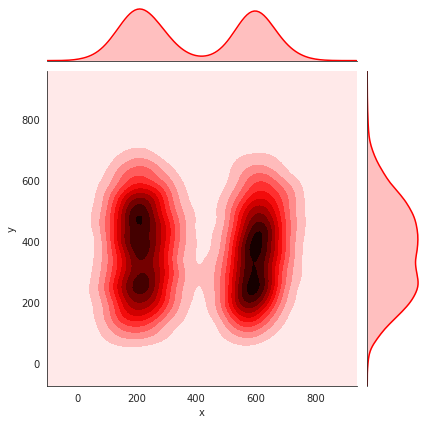

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="x", y="y", kind="kde", color="r",data=image_full_df[image_full_df.x >0])

#### Understanding Bounding Box Coordinates for Females

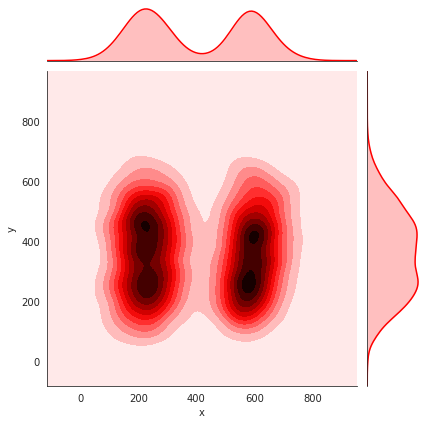

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="x", y="y", kind="kde", color="r",data=image_full_df[(image_full_df.x >0) & (image_full_df.PatientSex=='F')])

For Females we can see higher density lies in :

- For Left Lung : Range of Y-coordinate (380-550) & (220-300) & X-coordinate is 200

- For Right Lung : Range of Y-coordinate (200-550) & X-coordinate is 600, though there is slight decrease in density in between Y-Coordinate (380-390)

#### Understanding Bounding Box Coordinates for Males

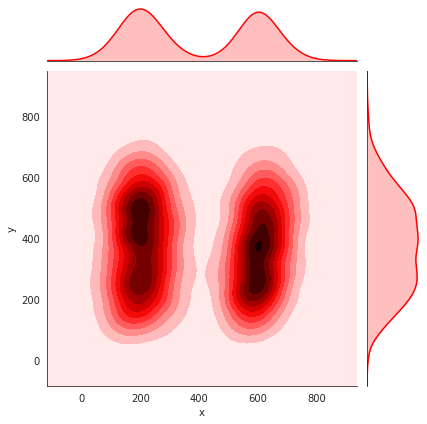

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="x", y="y", kind="kde", color="r",data=image_full_df[(image_full_df.x >0) & (image_full_df.PatientSex=='M')])

For Males we can see higher density lies in :

- For Left Lung : Range of between (380,200)&(580,200)

- For Right Lung : Range of Y-coordinate (200,600)(450,600)

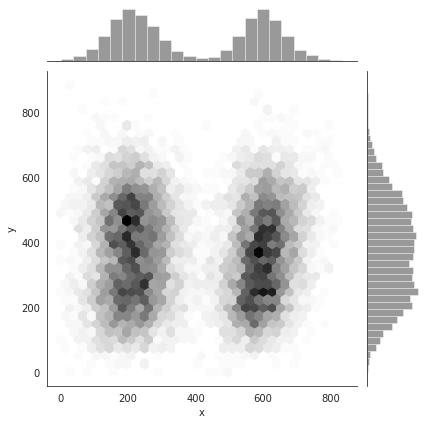

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="x", y="y", kind="hex", color="k",data=image_full_df[image_full_df.x >0]);

This above KDE plot is showing two distribution on left and right because of lungs , it is showing distribution of coordinates on each side of lung !

On left lung most of the bounding box lies in between range of (400,200) to (550,200)

On right lung most of the bounding box lies in between range of (200,600) to (400,600) 

We can say that mostly right lung is more affected than left

### Distribution of Height and Width of Bounding Box - understanding the Shape

**Shape Tells us the Level of Opacity. If shape is rectangle i assume that the opacity will be more , whereas if shape is square, I assume the opacity is less !

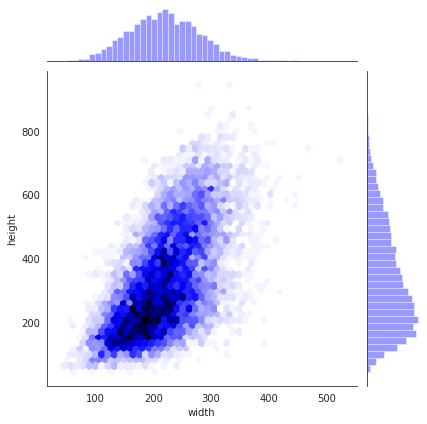

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height", kind="hex", color="b",data=image_full_df[image_full_df.x >0]);

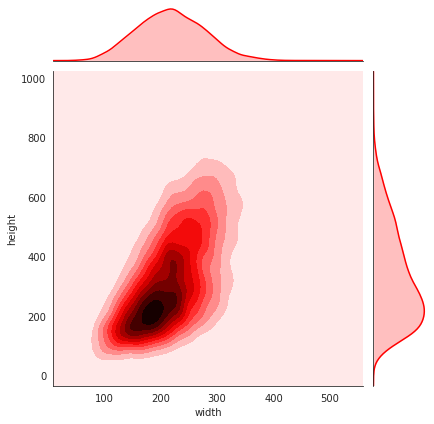

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height", kind="kde", color="r",data=image_full_df[image_full_df.x >0]);

#### Understanding Bounding Box Shape for Males

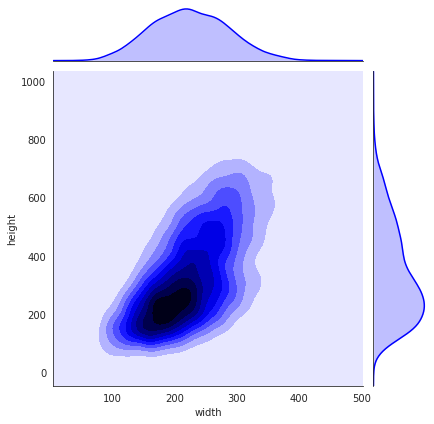

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height",kind='kde', color="b",data=image_full_df[(image_full_df.x >0) & (image_full_df.PatientSex=='M')]);

For Males we see that most of the boxes are squarish , high density can be seen at around ( 200,200)

There is only a single concentration in that area 

#### Understanding Bounding Box Shape for Females

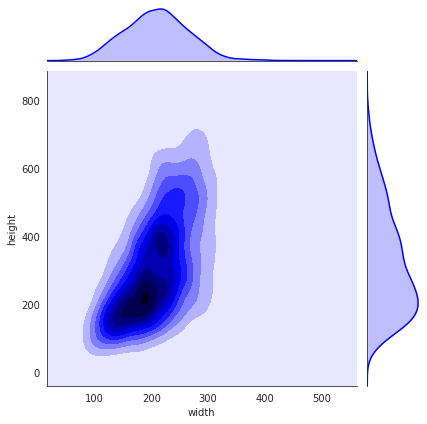

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height",kind='kde', color="b",data=image_full_df[(image_full_df.x >0) & (image_full_df.PatientSex=='F')]);

For Female there are two cluster forming of concentration , highest concentration is at (200,200) and the smaller concentration is there at (400,210)

### Understanding Pneumonia Location

Text(0.5, 1.01, 'Pneumonia location')

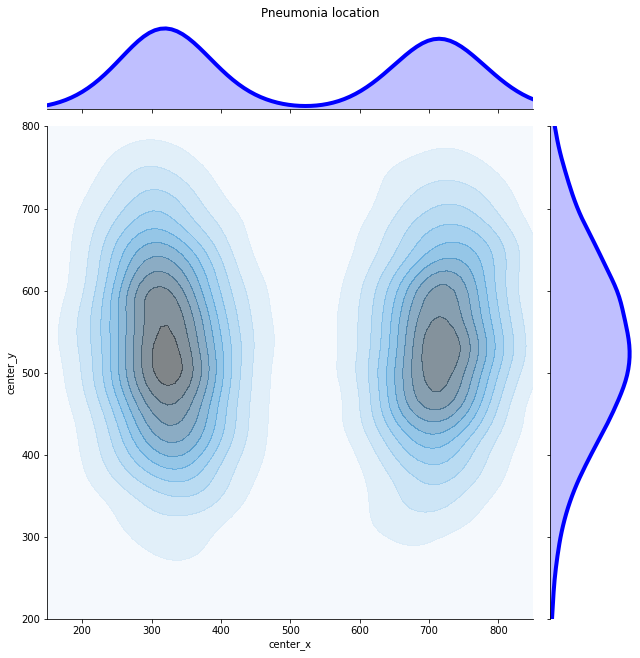

In [ ]:
centers = (image_full_df[image_full_df.x>0]).assign(center_x= image_full_df.x[image_full_df.x>0] + image_full_df.width[image_full_df.x>0] / 2, center_y=image_full_df.y[image_full_df.y>0] + image_full_df.height[image_full_df.y>0] / 2)

ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.5,xlim=(150,850), ylim=(200,800), kind='kde',marginal_kws={'lw':4,'color':'blue'})
ax.fig.suptitle("Pneumonia location", y=1.01)

- We notice that higher chances of opacity to be identified is in between :

- in left lung : (580,320) & (480,320)

- in right lung : (590,700) & (460,700)

#### Understanding Pneumonia Location for Males

Text(0.5, 1.01, 'Pneumonia location')

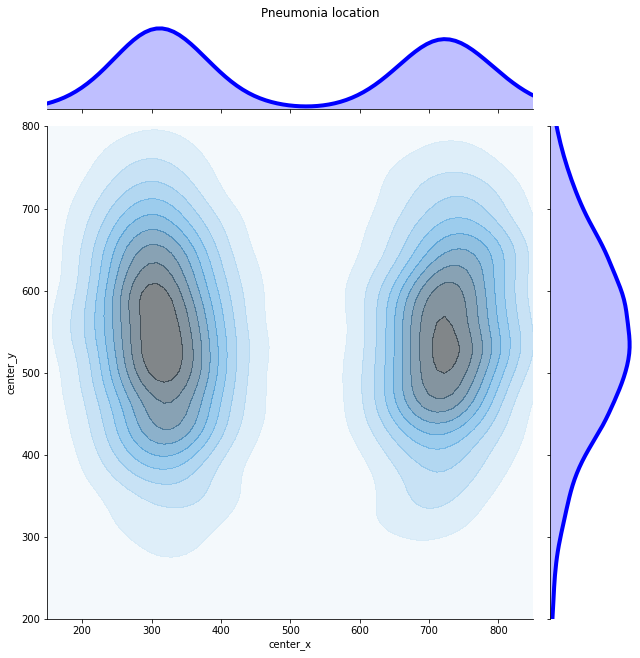

In [ ]:
centers = (image_full_df[(image_full_df.x>0)&(image_full_df.PatientSex=='M')]).assign(center_x= image_full_df.x[(image_full_df.x>0)&(image_full_df.PatientSex=='M')] + image_full_df.width[(image_full_df.x>0)&(image_full_df.PatientSex=='M')] / 2, center_y=image_full_df.y[(image_full_df.x>0)&(image_full_df.PatientSex=='M')] + image_full_df.height[(image_full_df.x>0)&(image_full_df.PatientSex=='M')] / 2)

ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.5,xlim=(150,850), ylim=(200,800), kind='kde',marginal_kws={'lw':4,'color':'blue'})
ax.fig.suptitle("Pneumonia location", y=1.01)

- We notice for Male, there are higher chances of opacity to be identified is in between :

- in left lung : (600,320) & (460,320)

- in right lung : (570,700) & (500,700)

#### Understanding Pneumonia Location for Females

Text(0.5, 1.01, 'Pneumonia location')

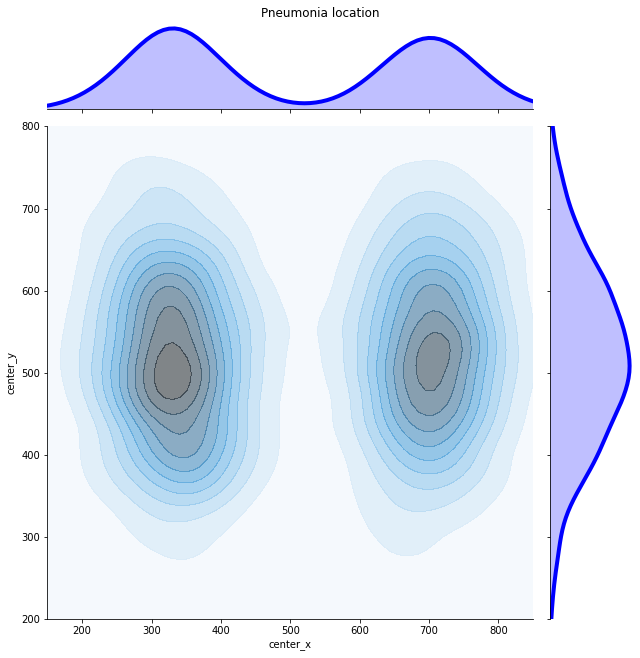

In [ ]:
centers = (image_full_df[(image_full_df.x>0)&(image_full_df.PatientSex=='F')]).assign(center_x= image_full_df.x[(image_full_df.x>0)&(image_full_df.PatientSex=='F')] + image_full_df.width[(image_full_df.x>0)&(image_full_df.PatientSex=='F')] / 2, center_y=image_full_df.y[(image_full_df.x>0)&(image_full_df.PatientSex=='F')] + image_full_df.height[(image_full_df.x>0)&(image_full_df.PatientSex=='F')] / 2)

ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.5,xlim=(150,850), ylim=(200,800), kind='kde',marginal_kws={'lw':4,'color':'blue'})
ax.fig.suptitle("Pneumonia location", y=1.01)

- We notice for Male, there are higher chances of opacity to be identified is in between :

- in left lung : (550,320) & (450,320)

- in right lung : (550,700) & (450,700)

### Lets focus on the age group between 40 to 65

In [ ]:
img_data=image_full_df[(image_full_df.PatientAge>39) & (image_full_df.PatientAge<66)]

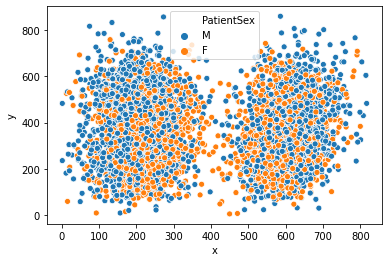

In [ ]:
sns.scatterplot(img_data.x[img_data.x >0],img_data.y[img_data.x >0],hue=img_data.PatientSex[img_data.x >0])

- Females in age between 40 to 60 have higher concentration of opacity on :

    - Left Lung : Higher concentration in left side , hence opacity is found in left side of the left lung
    
    - Right Lung : Higher concentration is on the right side.

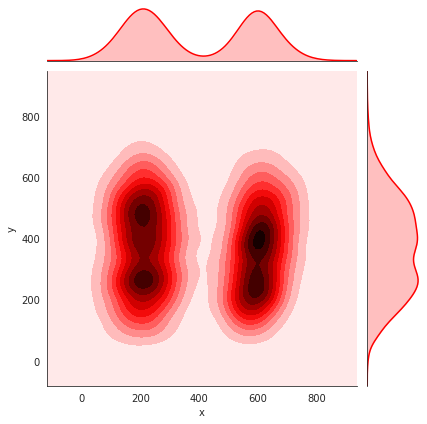

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="x", y="y", kind="kde", color="r",data=img_data[img_data.x >0])

For patients in age group between 45 to 65

- The prominent density is shown in the right lung between coordinates (390,600) to (410,600)

- Though there are formidible 2 clusters in left lung first is in between (220,200) to (300,200) and second cluster is (380,570)

#### Understanding Bounding Box Coordinates for Females

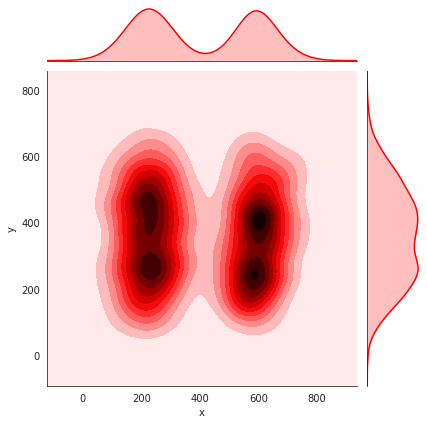

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="x", y="y", kind="kde", color="r",data=img_data[(img_data.x >0) & (img_data.PatientSex=='F')])

For female patients in age group between 45 to 65

- There are two cluster of prominent density in the right lung between, First Cluster:  coordinates (210,600) to (220,600) & Second Cluster (380,600) to ( 440 ,600)



#### Understanding Bounding Box Coordinates for Males

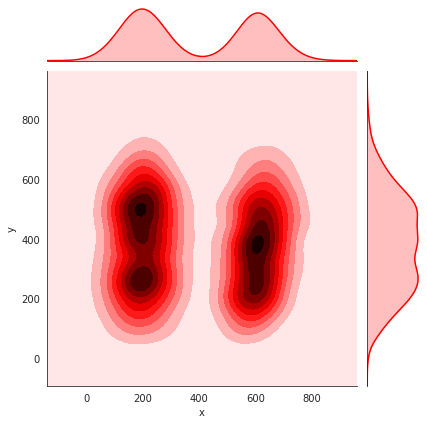

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="x", y="y", kind="kde", color="r",data=img_data[(img_data.x >0) & (img_data.PatientSex=='M')])

For male patients in age group between 45 to 65

- There is only one prominent density cluster seen in left lung around ( 500,200) to (505,200)



#### Distribution of Height and Width of Bounding Box - understanding the Shape for age group 40 to 65

**Shape Tells us the Level of Opacity. If shape is rectangle i assume that the opacity will be more , whereas if shape is square, I assume the opacity is less !

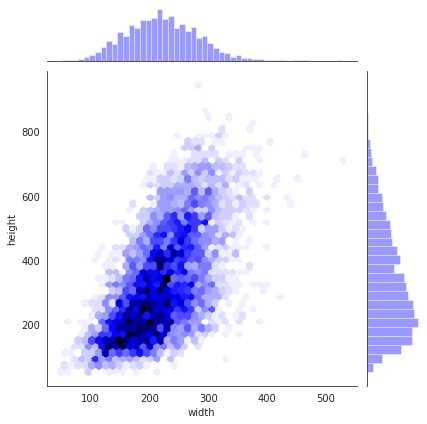

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height", kind="hex", color="b",data=img_data[img_data.x >0]);

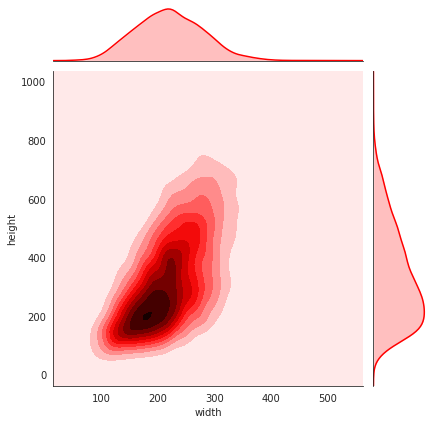

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height", kind="kde", color="r",data=img_data[img_data.x >0]);

#### Understanding Bounding Box Shape for Males

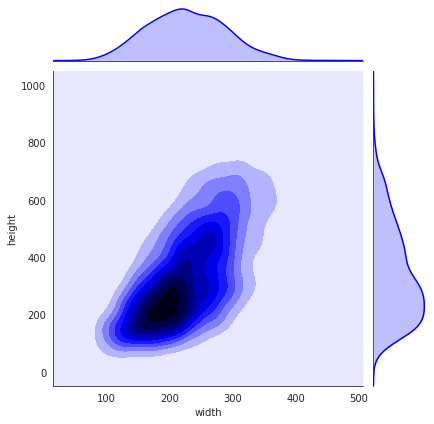

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height",kind='kde', color="b",data=img_data[(img_data.x >0) & (img_data.PatientSex=='M')]);

For Males we see that most of the boxes are squarish , high density can be seen between ( 250,200) & (180, 180)

There is only a single concentration in that area 

#### Understanding Bounding Box Shape for Females

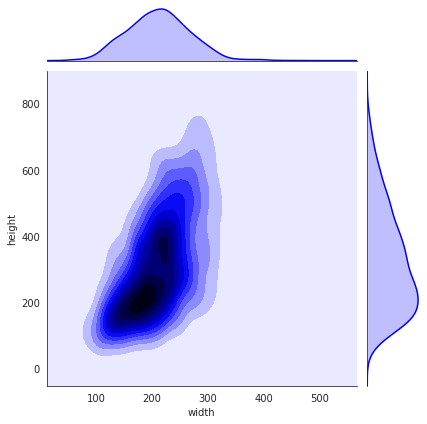

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height",kind='kde', color="b",data=img_data[(img_data.x >0) & (img_data.PatientSex=='F')]);

For Female there are two cluster forming of concentration , highest concentration is between (180,120) and (25,210)

### Understanding Pneumonia Location

Text(0.5, 1.01, 'Pneumonia location')

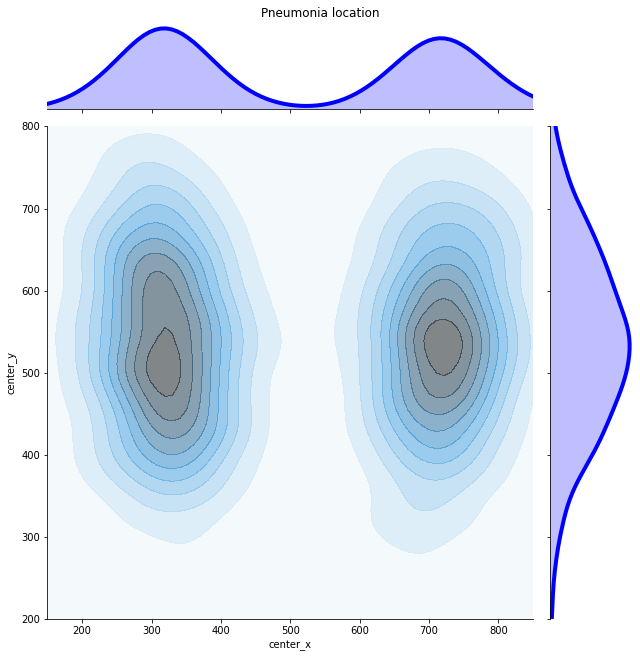

In [ ]:
centers = (img_data[img_data.x>0]).assign(center_x= img_data.x[img_data.x>0] + img_data.width[img_data.x>0] / 2, center_y=img_data.y[img_data.y>0] + img_data.height[img_data.y>0] / 2)

ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.5,xlim=(150,850), ylim=(200,800), kind='kde',marginal_kws={'lw':4,'color':'blue'})
ax.fig.suptitle("Pneumonia location", y=1.01)

- We notice that higher chances of opacity to be identified is in between :

- in left lung : (580,320) & (460,320)

- in right lung : (560,700) & (500,700)

#### Understanding Pneumonia Location for Males

Text(0.5, 1.01, 'Pneumonia location')

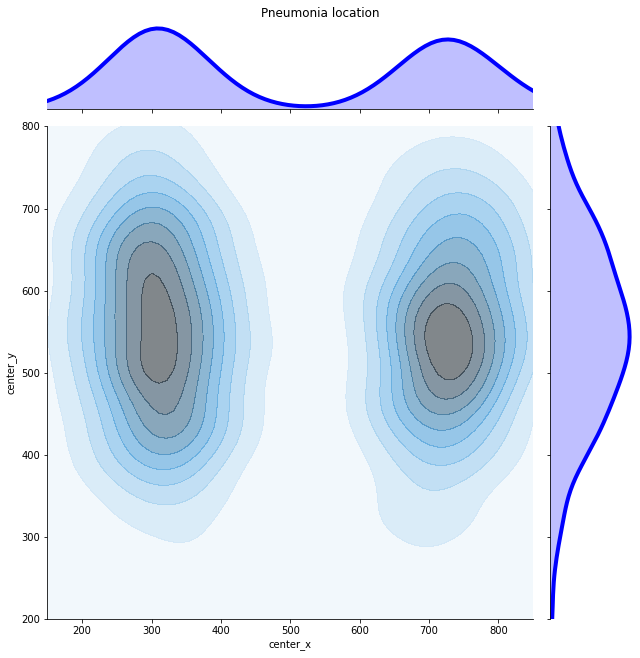

In [ ]:
centers = (img_data[(img_data.x>0)&(img_data.PatientSex=='M')]).assign(center_x= img_data.x[(img_data.x>0)&(img_data.PatientSex=='M')] + img_data.width[(img_data.x>0)&(img_data.PatientSex=='M')] / 2, center_y=img_data.y[(img_data.x>0)&(img_data.PatientSex=='M')] + img_data.height[(img_data.x>0)&(img_data.PatientSex=='M')] / 2)

ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.5,xlim=(150,850), ylim=(200,800), kind='kde',marginal_kws={'lw':4,'color':'blue'})
ax.fig.suptitle("Pneumonia location", y=1.01)

- We notice for Male, there are higher chances of opacity to be identified is in between :

- in left lung : (620,320) & (480,320)

- in right lung : (570,700) & (500,700)

#### Understanding Pneumonia Location for Females

Text(0.5, 1.01, 'Pneumonia location')

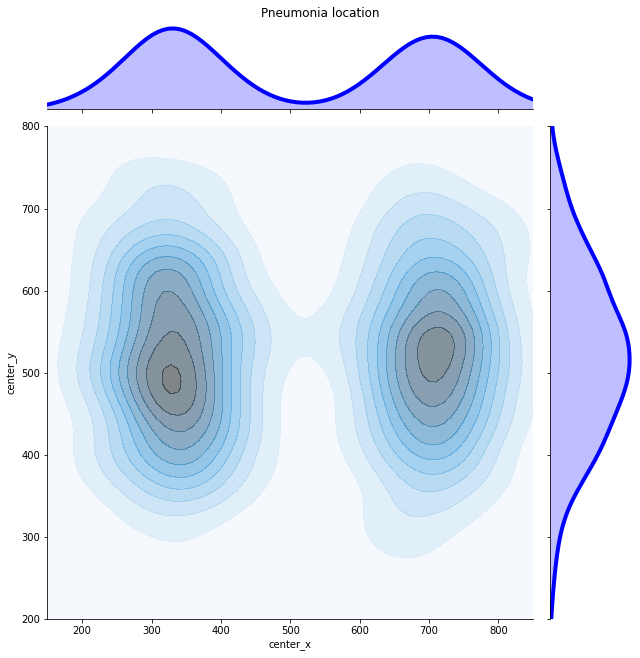

In [ ]:
centers = (img_data[(img_data.x>0)&(img_data.PatientSex=='F')]).assign(center_x= img_data.x[(img_data.x>0)&(img_data.PatientSex=='F')] + img_data.width[(img_data.x>0)&(img_data.PatientSex=='F')] / 2, center_y=img_data.y[(img_data.x>0)&(img_data.PatientSex=='F')] + img_data.height[(img_data.x>0)&(img_data.PatientSex=='F')] / 2)

ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.5,xlim=(150,850), ylim=(200,800), kind='kde',marginal_kws={'lw':4,'color':'blue'})
ax.fig.suptitle("Pneumonia location", y=1.01)

- We notice for female, there are higher chances of opacity to be identified is in between :

- in left lung : (500,320) & (480,320)

- in right lung : (550,700) & (490,700)

# Data Prepration for Modeling

### Splitting Data in Train and Validation Data

In [ ]:
sub_data=image_full_df[['Path','xmin','xmax','ymin','ymax','Target']]

In [ ]:
sub_data.head()

,Path,xmin,xmax,ymin,ymax,Target
0,/content/drive/My Drive/Capstone/train_images/...,0,0,0,0,0
1,/content/drive/My Drive/Capstone/train_images/...,0,0,0,0,0
2,/content/drive/My Drive/Capstone/train_images/...,316,486,318,796,1
3,/content/drive/My Drive/Capstone/train_images/...,660,806,375,777,1
4,/content/drive/My Drive/Capstone/train_images/...,570,839,282,691,1


### Loading Train and Validation Data

In [ ]:
train_X=pd.read_csv('Train_X.csv')
val_X=pd.read_csv('Val_X.csv')

## Image Data Generator

In [ ]:
#msk= np.zeros(img.shape)
class DataSequence(keras.utils.Sequence):

    def __init__(self, data):
        self.paths = []
        #self.mask=[]
        #self.msk= np.zeros(img.shape)
        self.coords=np.zeros((data.shape[0],4))
        for index,row in data.iterrows():
            for i,r in enumerate(row[1:5]):
                row[i+1]=int(r)
            path,xmin,xmax,ymin,ymax,_=row
            #msk[ymin:ymax,xmin:xmax]=1
            #self.mask.append(msk)
            self.coords[index,0]=xmin/IMAGE_SIZE
            self.coords[index,1]=ymin/IMAGE_SIZE
            self.coords[index,2]=xmax/IMAGE_SIZE
            self.coords[index,3]=ymax/IMAGE_SIZE
            self.paths.append(path)
        

        
    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)

    def __getitem__(self, idx): # Get a batch
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image path
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords

        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE,1), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            #img = Image.open(f) # Read image
            img = pydicom.dcmread(f).pixel_array
            img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
            #img = img.convert('RGB')
            img = np.expand_dims(img, -1)

            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
            #img.close()

        return batch_images, batch_coords
    

In [ ]:
class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs):
        intersections = 0
        unions = 0

        for i in range(len(self.generator)):
            batch_images, gt = self.generator[i] # Get batch
            pred = self.model.predict_on_batch(batch_images) # Predict bbox on batch

            # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = diff_width * diff_height

            # Compute union
            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = area_gt + area_pred - intersection

            # Compute intersection and union over multiple boxes
            for j, _ in enumerate(union):
                if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
                    intersections += intersection[j]
                    unions += union[j]

        # Compute IOU. Use epsilon to prevent division by zero
        iou = np.round(intersections / (unions + epsilon()), 4)
        logs["val_iou"] = iou

        print(" - val_iou: {}".format(iou))

### Model Parameters

In [ ]:

IMAGE_SIZE = 128 # Image sizes can vary (128, 160, 192, 224)

EPOCHS = 4 
BATCH_SIZE = 32 
PATIENCE = 10 # Patience for early stopping

MULTI_PROCESSING = False 
THREADS = 1 


### Initializing Data Generator

In [ ]:
train_datagen = DataSequence(train_X)
val_data=Validation(generator=DataSequence(val_X))

## Model 1

In [ ]:
def downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.99)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(3)(x)
    return x

def resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.99)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.99)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = downsample(channels, x)
        for b in range(n_blocks):
            x = resblock(channels, x)
    
    x = keras.layers.BatchNormalization(momentum=0.99)(x)
    x = keras.layers.LeakyReLU(0)(x)
    outputs = keras.layers.Conv2D(12,(1,1))(x)
    
    outputs = keras.layers.Conv2D(64,(3,3), strides=(2,2))(outputs)
    outputs = keras.layers.Conv2D(12,(3,3),padding='valid')(outputs)
    outputs = keras.layers.Conv2D(32,(3,3), 2)(outputs)
    #outputs = keras.layers.Conv2D(12,(1,1))(outputs)
    
    #outputs = keras.layers.Conv2D(channels,(3,3),2)(outputs)
    #outputs = keras.layers.Conv2D(12,(1,1))(outputs)
    #outputs = keras.layers.Conv2D(channels,(3,3),2 )(outputs)

    
        #x = keras.layers.MaxPooling2D((3,3),strides=(2,2))(x)
    outputs = keras.layers.Conv2D(4,(1,1))(outputs)

        #outputs = keras.layers.UpSampling2D(2**depth)(x)
    outputs = Reshape((4,))(outputs) 
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
model = create_network(input_size=128, channels=32, n_blocks=2, depth=2)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 32) 288         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 128, 128, 32) 128         conv2d_16[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 128, 128, 32) 0           batch_normalization_11[0][0]     
____________________________________________________________________________________________

In [ ]:
model.load_weights('Model-vGbG-0.24.h5')

In [ ]:
optimizer=keras.optimizers.SGD(learning_rate=.01,momentum=.9,decay=.0001,nesterov=True)
#model.compile(loss=, optimizer=optimizer, metrics=['accuracy'])
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])
checkpoint = ModelCheckpoint("Model-vGbG-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

history=model.fit_generator(generator=train_datagen,
                    epochs=4,
                    callbacks=[val_data, checkpoint, reduce_lr, stop],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Epoch 1/4
  2/662 [..............................] - ETA: 14:42 - loss: 2.8408 - accuracy: 0.1875

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.epoch, history.history["val_iou"])
plt.title('IOU')
plt.xlabel("Epochs")
plt.ylabel("validation iou")
plt.show()

## Model 2 - On VGG Architecture

<img src='https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/Plot-of-Convolutional-Neural-Network-Architecture-with-Multiple-VGG-Blocks-440x1024.png'>

In [ ]:
def vgg_block(layer_in, n_filters, n_conv):
    for _ in range(n_conv):
        layer_in = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = keras.layers.MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in
 
# define model input


<img src="https://miro.medium.com/max/2000/1*hdSE1UCV7gA7jzfQ03EnWw.png">

In [ ]:
visible = keras.layers.Input(shape=(224, 224, 1))
# add vgg module
layer = vgg_block(visible, 12, 2)
layer = vgg_block(layer, 18, 2)
#layer=keras.layers.BatchNormalization(momentum=0.99)(layer)
layer = vgg_block(layer, 24, 2)
#layer=keras.layers.Dropout(.2)(layer)
#layer=Conv2D(6,(1,1),activation='relu')(layer)
layer = vgg_block(layer, 30, 3)
#layer=keras.layers.BatchNormalization(momentum=0.99)(layer)
layer = vgg_block(layer, 24, 3)
layer=Conv2D(30, (3,3), padding='valid',strides=(2,2), activation='relu')(layer)
layer=Conv2D(30, (3,3), padding='same', activation='relu')(layer)
#layer=Conv2D(4,(1,1))(layer)

#layer=keras.layers.MaxPooling2D((3,3),strides=(2,2))(layer)
layer=Conv2D(30, (3,3), padding='valid', activation='relu')(layer)
#layer=Conv2D(4, (3,3),padding='valid', activation='relu')(layer)
#layer=Conv2D(4, (3,3),strides=(2,2), activation='relu')(layer)
layer=Conv2D(4,(1,1))(layer)
layer= Reshape((4,))(layer)

# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()

In [ ]:
#model.compile(loss='mean_squared_error', optimizer="adam", metrics=['accuracy']) # Regression loss is MSE
optimizer=keras.optimizers.SGD(learning_rate=.01,momentum=.9,decay=.0001,nesterov=True)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
checkpoint = ModelCheckpoint("Model-vGG-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

history=model.fit_generator(generator=train_datagen1,
                    epochs=5,
                    callbacks=[val_data1, checkpoint, reduce_lr, stop],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.epoch, history.history["val_iou"])
plt.title('IOU')
plt.xlabel("Epochs")
plt.ylabel("validation iou")
plt.show()

# Model 3

<img src='https://miro.medium.com/max/742/1*XFvQWA4VESeQIcxzXMHCAg.png'>

In [ ]:
def depth_conv_block(layer_in,channels,s=1):
    layer_in=keras.layers.DepthwiseConv2D(kernel_size=(3,3),strides=(s,s),padding='same')(layer_in)
    layer_in=keras.layers.BatchNormalization()(layer_in)
    layer_in=keras.layers.Activation('relu')(layer_in)
    layer_in=Conv2D(channels,(1,1))(layer_in)
    layer_in=keras.layers.BatchNormalization()(layer_in)
    layer_in=keras.layers.Activation('relu')(layer_in)
    return layer_in

def conv_block(layer_in,channels,s=1,f=3):
    layer_in=Conv2D(channels,(f,f),strides=(s,s),padding='same')(layer_in)
    layer_in=keras.layers.BatchNormalization()(layer_in)
    layer_in=keras.layers.Activation('relu')(layer_in)
    return layer_in

visible=keras.layers.Input(shape=(128,128,1))
layer=conv_block(visible,6,s=2)
layer=depth_conv_block(layer,6)
layer=conv_block(layer,12,s=1,f=1)
layer=depth_conv_block(layer,12,s=2) 
layer=conv_block(layer,18,s=1,f=1)
layer=depth_conv_block(layer,18,s=1) 
layer=conv_block(layer,18,s=1,f=1)
layer=depth_conv_block(layer,18,s=2) 
layer=conv_block(layer,24,s=1,f=1)
layer=depth_conv_block(layer,24,s=1)
layer=conv_block(layer,24,s=1,f=1)
layer=depth_conv_block(layer,24,s=2)
layer=conv_block(layer,30,s=1,f=1)  
for _ in range(3):
    layer=depth_conv_block(layer,30,s=1)
    layer=conv_block(layer,30,s=1,f=1) 
layer=depth_conv_block(layer,30,s=2)
layer=keras.layers.Activation('linear')(layer)
layer=keras.layers.AveragePooling2D((4,4))(layer)
layer=Conv2D(4,(1,1))(layer)
layer = Reshape((4,))(layer)



model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()    

In [ ]:
keras.optimizers.SGD?

In [ ]:
optimizer=keras.optimizers.SGD(learning_rate=.01,momentum=.9,decay=.0001,nesterov=True)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy']) # Regression loss is MSE


checkpoint = ModelCheckpoint("Model-Blended-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

history=model.fit_generator(generator=train_datagen,
                    epochs=3,
                    callbacks=[val_data, checkpoint, reduce_lr, stop],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.epoch, history.history["val_iou"])
plt.title('Validation Intersection over Union')
plt.xlabel("Epochs")
plt.ylabel("Val-IOU")
plt.figure(figsize=(12,4))
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")



In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

- Potenital reason for why mobilenet did not perform better is because , mobilenet takes image size of (96,128,196,224) but our image size is 1024 but we have resized it to 128 , since the image is a grey scale image there lies high sparcity, hence resizing is not a good idea . For our computational constraint , we have resized the image 

# Key Highlights for you from model  

- For Computational Constraints we have used very less number of filters

- We have tried to blend SSD & State of Art Model

- We are not using Fully Connected Layer as we are using 1x1 convolution as a fully connected layer 

- Models have poorly performed due to less number of filters and also because our image is of grey-scale, of size 1024x1024 but when we are using them as input , it has been converted as 128x128. As the grey scale image is already sparced, when we resize it to 128x128 it looses on lot of information.



# Mask RCNN IMplementation

**Deprecating tensorflow and Keras due to compatibility issue in Pre Trained Mask RCNN Model**

https://github.com/matterport/Mask_RCNN/issues/1797

In [ ]:
%tensorflow_version 1.13.1    
!pip install q keras==2.1.0

import warnings
warnings.filterwarnings('ignore')

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.13.1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
# Install dependencies not included by Colab

!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug

import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob

In [ ]:
#Defining Directories for the Project

# Root directory of the project
ROOT_DIR = os.path.abspath('/content/drive/My Drive/Capstone')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

In [ ]:
#Cloning Matterport’s Mask-RCNN model from Github to Google Drive

os.chdir(ROOT_DIR)
#!git clone https://github.com/matterport/Mask_RCNN.git

os.chdir('Mask_RCNN')
#!python setup.py -q install


# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

train_dicom_dir = os.path.join(ROOT_DIR, 'train_images')

Using TensorFlow backend.


In [ ]:
#Setting up Functions and Default Configurations:

def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 


#Overriding Base Config file

class DetectorConfig(Config):
 
    NAME = 'pneumonia'                                      # Providing Configuration file a recognizable name 
    GPU_COUNT = 1                                           # Number of GPU available to run the model for Local Machine
    IMAGES_PER_GPU = 8 
    BACKBONE = 'resnet50'
    NUM_CLASSES = 2                                         # background + 1 pneumonia classes
    IMAGE_MIN_DIM = 64                                      # Nearest to the original size of the image, the better, but will make the training slower.
    IMAGE_MAX_DIM = 64
    RPN_ANCHOR_SCALES = (32, 64)
    TRAIN_ROIS_PER_IMAGE = 16                               # Indicates how many true positive + negative ROIs from the RPN to use for training the ODN network.
    MAX_GT_INSTANCES = 3                                    # Defines an upper limit to the number of ground-truth object instances per image.
    DETECTION_MAX_INSTANCES = 3                             # Takes the top DETECTION_MAX_INSTANCES scores proposals after NMS for object classification and BB regression in order to speed up inference time.
    DETECTION_MIN_CONFIDENCE = 0.9                          # Sets the limit to consider a detection depending of its confidence. ROIs below this threshold are ignored.
    DETECTION_NMS_THRESHOLD = 0.1                           # Non Max Suppression used to eliminate duplicate bounding boxes that may be detected for the same opacity,ideally should be only one opacity per each detection.
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16                        # Anchors per image to use for RPN training
    STEPS_PER_EPOCH = 100                                   # Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch.
    TOP_DOWN_PYRAMID_SIZE = 32                              # Size of the top-down layers used to build the feature pyramid.
    

config = DetectorConfig()
config.display()  


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     

In [ ]:
#Dataset class for training pneumonia detection on the RSNA pneumonia dataset


class DetectorDataset(utils.Dataset):

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)


*   **dicom_fps** is a list of the dicom image path and filenames
*   **image_annotions** is a dictionary of the annotations keyed by the filenames
*   **parsing** the dataset returns a list of the image filenames and the annotations dictionary

In [ ]:
# Loading the Annotations

anns = pd.read_csv(os.path.join(ROOT_DIR, 'stage_2_train_labels.csv'))
anns.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [ ]:
# Printing the dicom fields that contain metadata

image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6810.1517874327.962459
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6810.1517874327.962459
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [ ]:
# Spliting the data into training and validation datasets

ORIG_SIZE = 1024

image_fps_list = list(image_fps)

sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.25
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

# prepare the training dataset using the DetectorDataset class
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

20014 6672




1.   dataset_train and dataset_val are derived from DetectorDataset
2.   DetectorDataset loads images from image filenames and masks from the annotation data
3.   Model is Mask-RCNN


In [ ]:
# Observing annotations for a DICOM image

test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    584f7e37-6bbf-4194-b671-61bcf49c56e5
 x                                             198
 y                                             303
 width                                         177
 height                                        369
 Target                                          1
 Name: 7597, dtype: object, patientId    584f7e37-6bbf-4194-b671-61bcf49c56e5
 x                                             521
 y                                             316
 width                                         232
 height                                        416
 Target                                          1
 Name: 7598, dtype: object]

(1024, 1024, 3)
/content/drive/My Drive/Capstone/train_images/7e68dd71-1e3e-4fa6-80ea-fa2a226aa06e.dcm
[1 1]


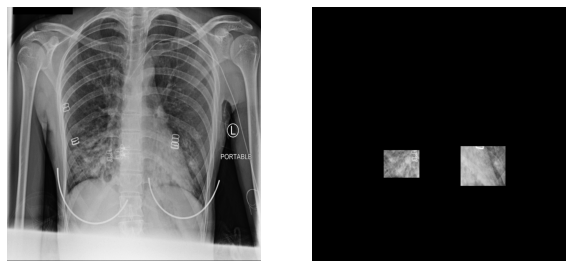

In [ ]:
# Loading and display random samples and their bounding boxes

image_id = random.choice(dataset_train.image_ids)#choose a random image
image_fp = dataset_train.image_reference(image_id)#image file path
image = dataset_train.load_image(image_id)#load the chosen image
mask, class_ids = dataset_train.load_mask(image_id)#load mask of the chosen img

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [ ]:
# Finetuning image augmentation variables to custom values

augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

## Loss Definations

1.   **rpn_class_loss** = RPN anchor classifier loss
2.   **rpn_bbox_loss** = RPN bounding box loss graph
3.   **mrcnn_class_loss** = loss for the classifier head of Mask R-CNN
4.   **mrcnn_bbox_loss** = loss for Mask R-CNN bounding box refinement
5.   **mrcnn_mask_loss** = mask binary cross-entropy loss for the masks head


https://stackoverflow.com/questions/55360262/what-exactly-are-the-losses-in-matterport-mask-r-cnn


In [ ]:
#Defining the Model

modelMRCNN = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)







Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


![alt text](https://miro.medium.com/max/1400/1*dYb3w2iVxkN7Ifx-eA8ZRg.jpeg)


In [ ]:
NUM_EPOCHS = 10

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
modelMRCNN.train(dataset_train,
            dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all',
            augmentation=augmentation)


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/Capstone/logs/pneumonia20200702T1036/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (C

InvalidArgumentError: ignored